# Term Deposit Marketing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt

## Data Exploration

In [3]:
data = pd.read_csv(r'/kaggle/input/term-deposit-marketing-2020/term-deposit-marketing-2020.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
counts = data.y.value_counts()
pcts = data.y.value_counts(normalize = True) * 100
print(pd.concat([counts, pcts], axis=1))

     count  proportion
y                     
no   37104       92.76
yes   2896        7.24


In [4]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [5]:
data.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
numerical_cols = [col for col in data.columns if data[col].dtype != 'object']

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign']


In [5]:
data['y'] = data['y'].map({'no':0,'yes':1})

In [9]:
print('unique values for categorical features are:')
for c in categorical_cols:
  x  = data[c].unique()
  print(f'{c}: {x} -- {len(x)} values\n')

unique values for categorical features are:
job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student'] -- 12 values

marital: ['married' 'single' 'divorced'] -- 3 values

education: ['tertiary' 'secondary' 'unknown' 'primary'] -- 4 values

default: ['no' 'yes'] -- 2 values

housing: ['yes' 'no'] -- 2 values

loan: ['no' 'yes'] -- 2 values

contact: ['unknown' 'cellular' 'telephone'] -- 3 values

month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr'] -- 11 values

y: [0 1] -- 2 values



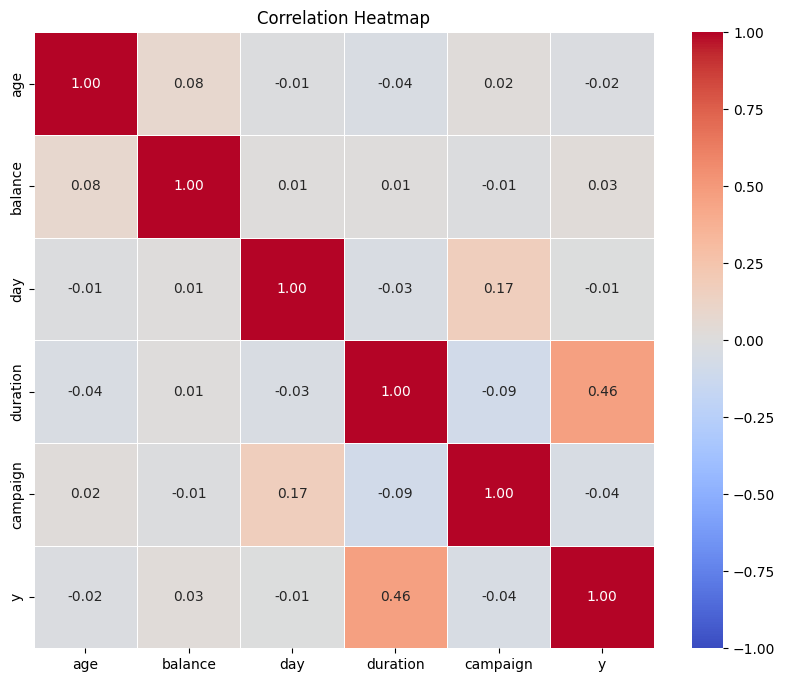

In [6]:
corr_matrix = data[numerical_cols + ['y']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title('Correlation Heatmap')
plt.show()

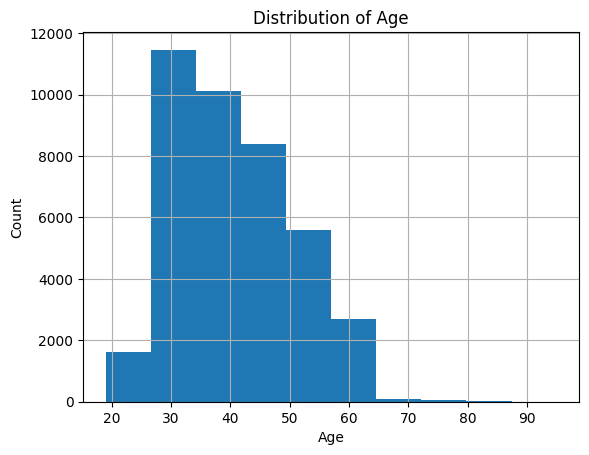

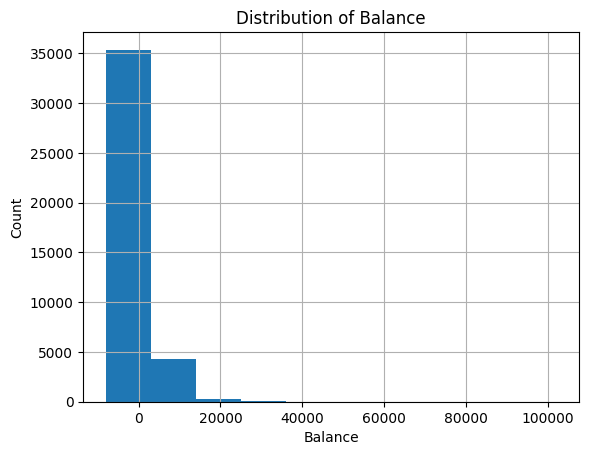

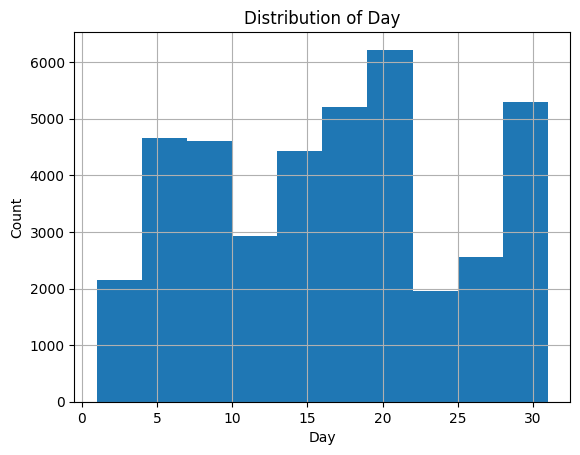

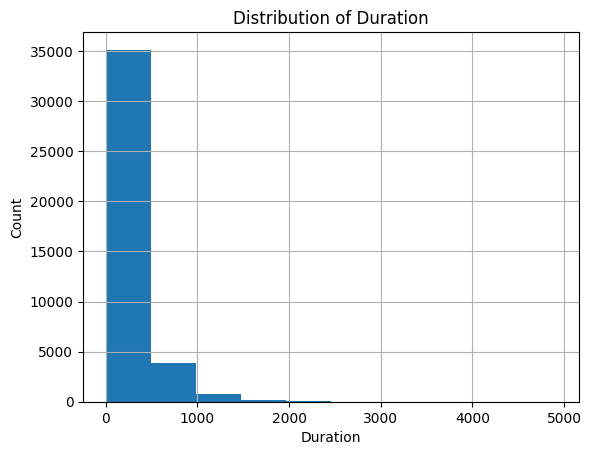

In [10]:
# Histograms for select numeric features
for col in numerical_cols[:-1]:
    plt.figure()
    data[col].hist()
    plt.title(f'Distribution of {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.show()

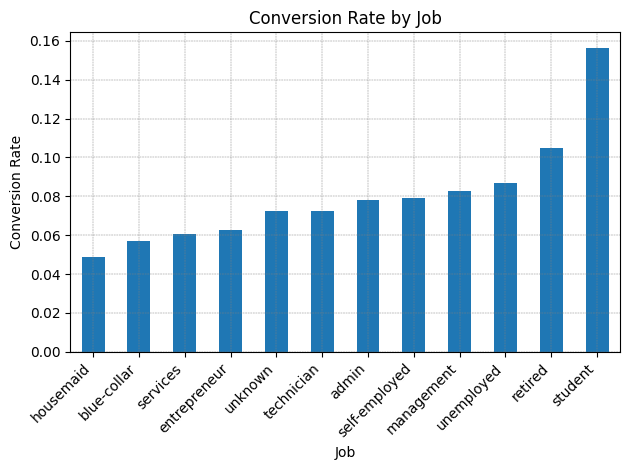

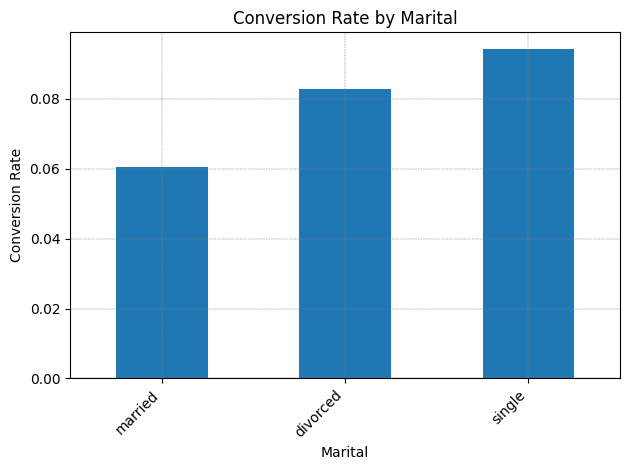

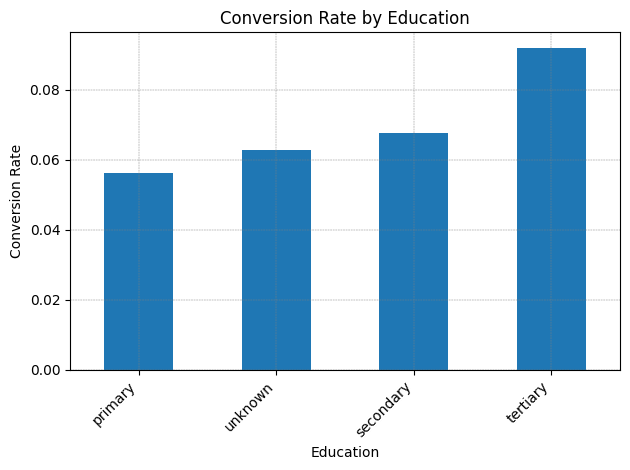

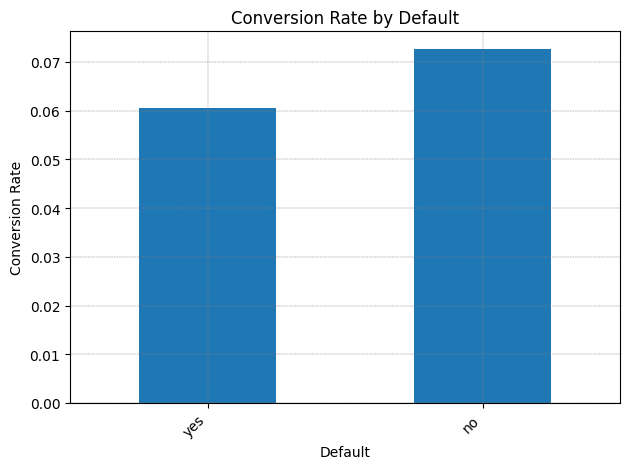

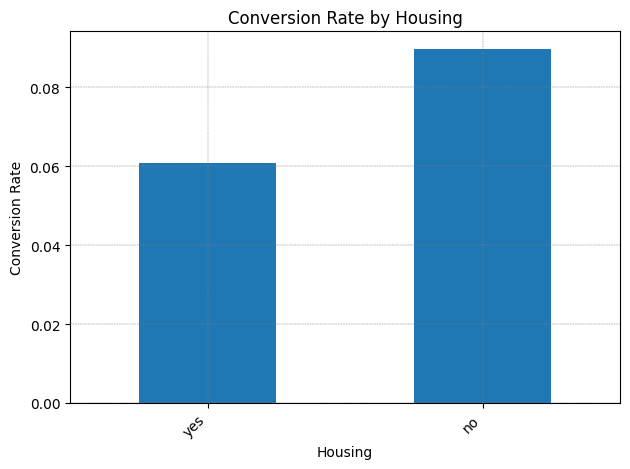

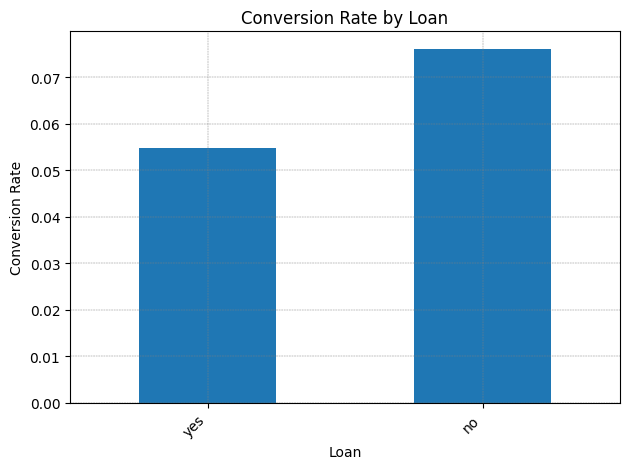

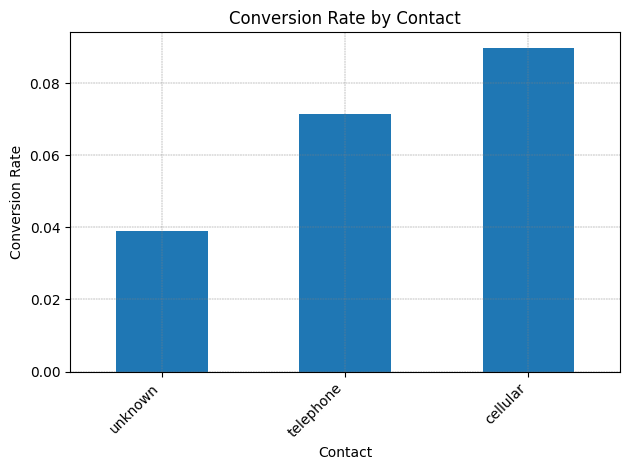

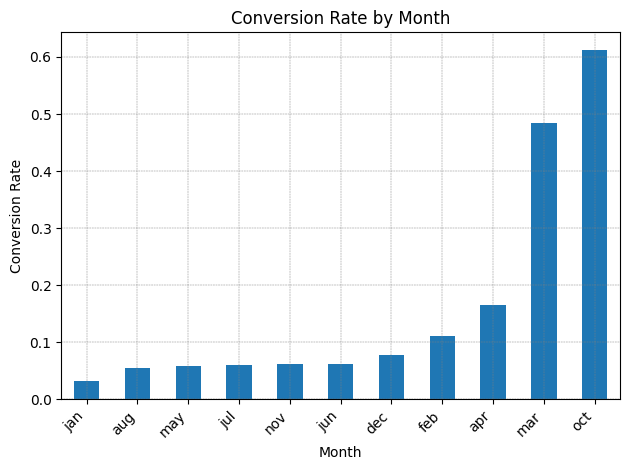

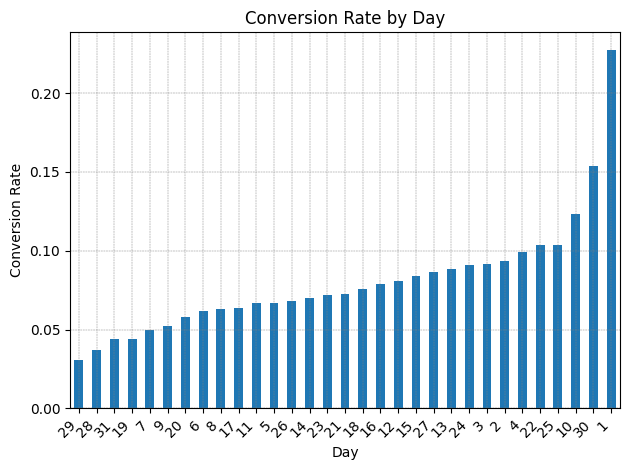

In [11]:
# Plot conversion rate for each category
for col in categorical_cols[:-1] + ['day']:
    conversion_rates = data.groupby(col)['y'].mean().sort_values()
    plt.figure()
    conversion_rates.plot(kind='bar')
    plt.title(f'Conversion Rate by {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.35)
    plt.show()

#### From the intial exploration we can make a few observations: 
1. Distribution of **campaign**, **duration**, and **balance** is highly skewed
2. The data is not balanced, not many users have converted
3. Conversion is highly correlated with duration of the call made. This is natural as longer calls could mean users who are more seriously considering the offer. But won't be of much help as a guide.
4. Conversion rate is higher for students and retired users which makes sense as these are the two groups that might benefit and financially make sense for them to use a term deposit account
5. Conversion is higher for teritary education, while secondary education doesn't make much difference. In general conversion goes up with higher education
6. Loan or mortgage makes opting for deposit acount less likely which could be attributed to the less financial freedom and more need for liquidity when paying off loans
7. Conversions are significantly higher for October and March (Why?)
8. Higher conversion when last call is made first or last day of the month. Also distribution shows multiple peaks at first 5 days, 15th to 20th, and last days of the month.

## Feature Engineering & First Model

**Feature Engineering:**
* For binary variables we convert them to 0 and 1
* For month, we convert to month number, 1-12
* For education we map to numbers while keeping unknown as -1
* job, contact, and marital status will be one hot encoded
* Numerical columns like balance and duration are standard scaled

**Models:**
* We test logistic regression, random forest, and xgboost
* We use cross validation and test the final model on a hold out set to get final score

In [6]:
X = data.drop(columns=['y'])
y = data['y']
X_train, X_hold, y_train, y_hold = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [7]:
# 3. One-hot encode the yes/no flags
X_train = pd.get_dummies(X_train, columns=['default','housing','loan'])
X_hold  = pd.get_dummies(X_hold,  columns=['default','housing','loan'])

# 4. Month → numeric
month_map = {
    'jan':1,  'feb':2,  'mar':3,  'apr':4,
    'may':5,  'jun':6,  'jul':7,  'aug':8,
    'sep':9,  'oct':10, 'nov':11, 'dec':12
}
X_train['month'] = X_train['month'].map(month_map)
X_hold['month']  = X_hold['month'].map(month_map)

# 5. Group jobs & one-hot
job_map = {
    'management':'white_collar','admin':'white_collar',
    'entrepreneur':'white_collar','self-employed':'white_collar',
    'technician':'white_collar',
    'blue-collar':'blue_collar','services':'blue_collar','housemaid':'blue_collar',
    'retired':'retired','unemployed':'unemployed','student':'student',
    'unknown':'unknown'
}
for df_ in (X_train, X_hold):
    df_['job_group'] = df_['job'].map(job_map)
X_train = pd.get_dummies(X_train, columns=['job_group'])
X_hold  = pd.get_dummies(X_hold,  columns=['job_group'])

# 6. Contact → cellular vs non-cellular + one-hot
for df_ in (X_train, X_hold):
    df_['contact_type'] = df_['contact'].apply(
        lambda x: 'cellular' if x=='cellular' else 'non_cellular'
    )
X_train = pd.get_dummies(X_train, columns=['contact_type'])
X_hold  = pd.get_dummies(X_hold,  columns=['contact_type'])

# 7. One-hot encode marital & education
X_train = pd.get_dummies(X_train, columns=['marital','education'])
X_hold  = pd.get_dummies(X_hold,  columns=['marital','education'])

# 8. Align columns (fill missing dummies with 0)
X_train, X_hold = X_train.align(X_hold, join='left', axis=1, fill_value=0)

# 9. Scale numeric columns
numerical_cols = ['age','balance','day','duration','campaign','month']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_hold[numerical_cols]  = scaler.transform(X_hold[numerical_cols])

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

X_train = X_train.drop(columns=categorical_cols)
X_hold  = X_hold.drop(columns=categorical_cols)

In [9]:
X_train.head()

,age,balance,day,month,duration,campaign,default_no,default_yes,housing_no,housing_yes,...,job_group_white_collar,contact_type_cellular,contact_type_non_cellular,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown
35752,-0.053962,-0.440161,-0.971979,-0.440458,-0.086703,-0.582039,True,False,False,True,...,True,True,False,False,True,False,False,False,True,False
10898,0.361478,0.139638,0.116451,-0.004267,-0.519866,-0.582039,True,False,False,True,...,False,False,True,False,True,False,False,True,False,False
27424,-0.677122,1.784360,0.600197,2.176693,-0.902752,1.281075,True,False,False,True,...,False,True,False,False,True,False,False,True,False,False
17179,-0.780982,-0.319571,1.446753,0.431925,-0.744183,0.038999,True,False,False,True,...,True,True,False,False,True,False,False,False,True,False
7744,-0.884842,-0.451909,1.688627,-0.440458,3.796298,-0.271520,True,False,False,True,...,False,False,True,False,True,False,False,True,False,False



=== Logistic Regression ===
Confusion Matrix:
[[7334   87]
 [ 443  136]]

Classification Report:
              precision    recall  f1-score   support

           0      0.943     0.988     0.965      7421
           1      0.610     0.235     0.339       579

    accuracy                          0.934      8000
   macro avg      0.776     0.612     0.652      8000
weighted avg      0.919     0.934     0.920      8000

Accuracy: 0.934

=== Random Forest ===
Confusion Matrix:
[[7319  102]
 [ 414  165]]

Classification Report:
              precision    recall  f1-score   support

           0      0.946     0.986     0.966      7421
           1      0.618     0.285     0.390       579

    accuracy                          0.935      8000
   macro avg      0.782     0.636     0.678      8000
weighted avg      0.923     0.935     0.924      8000

Accuracy: 0.935

=== XGBoost ===
Confusion Matrix:
[[7291  130]
 [ 351  228]]

Classification Report:
              precision    recall  f1-

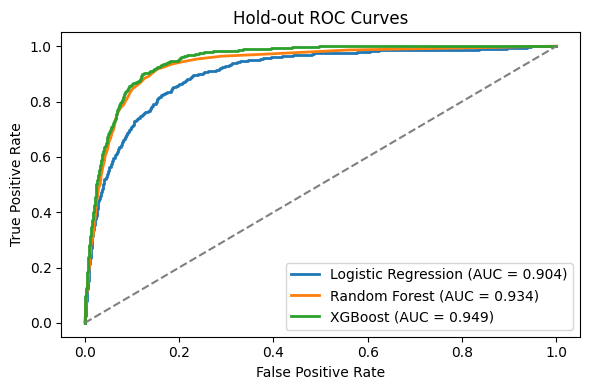

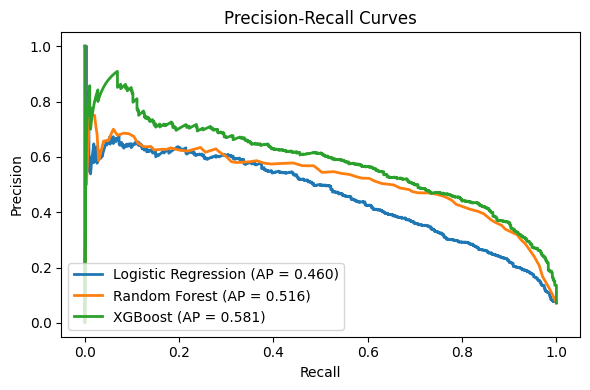

In [10]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Evaluate on hold-out set
plt.figure(figsize=(6, 4))
for name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    # Predictions
    y_pred = model.predict(X_hold)
    y_prob = model.predict_proba(X_hold)[:, 1]
    
    # Confusion matrix and classification report
    print(f"\n=== {name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_hold, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_hold, y_pred, digits=3))
    print(f"Accuracy: {accuracy_score(y_hold, y_pred):.3f}")
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_hold, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Plot ROC
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hold-out ROC Curves')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Precision-Recall curve
plt.figure(figsize=(6, 4))
for name, model in models.items():
    y_prob = model.predict_proba(X_hold)[:, 1]
    precision, recall, _ = precision_recall_curve(y_hold, y_prob)
    ap = average_precision_score(y_hold, y_prob)
    plt.plot(recall, precision, lw=2, label=f'{name} (AP = {ap:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


Logistic Regression 5-Fold CV Results:


,accuracy,recall,roc_auc
Fold 1,0.933125,0.259179,0.901203
Fold 2,0.932656,0.246220,0.909710
Fold 3,0.933594,0.220302,0.900198
Fold 4,0.934688,0.191810,0.894734
Fold 5,0.930781,0.239224,0.896076


Mean scores:


,accuracy,recall,roc_auc
mean,0.932969,0.231347,0.900384


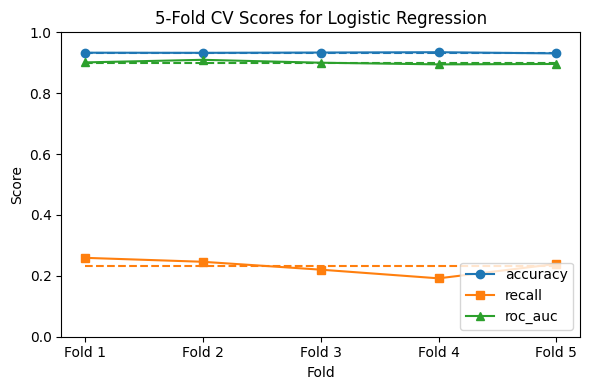


Random Forest 5-Fold CV Results:


,accuracy,recall,roc_auc
Fold 1,0.931562,0.304536,0.926097
Fold 2,0.936406,0.302376,0.939094
Fold 3,0.932031,0.265659,0.931043
Fold 4,0.934531,0.234914,0.935691
Fold 5,0.933594,0.297414,0.936160


Mean scores:


,accuracy,recall,roc_auc
mean,0.933625,0.28098,0.933617


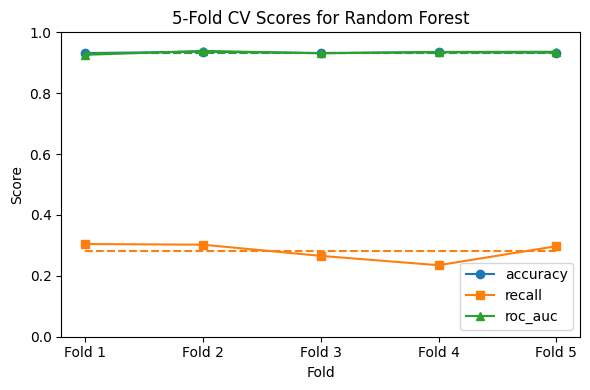


XGBoost 5-Fold CV Results:


,accuracy,recall,roc_auc
Fold 1,0.937500,0.419006,0.943009
Fold 2,0.936719,0.377970,0.949695
Fold 3,0.939063,0.388769,0.950377
Fold 4,0.939063,0.331897,0.949864
Fold 5,0.937187,0.420259,0.947286


Mean scores:


,accuracy,recall,roc_auc
mean,0.937906,0.38758,0.948046


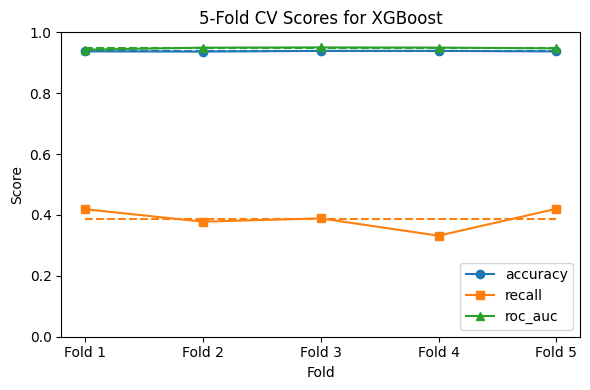

In [16]:
# 1. 5-Fold CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'recall', 'roc_auc']

# 2. Run CV for each model and report/plot results
for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)
    
    # Build a DataFrame of test scores
    cv_df = pd.DataFrame({
        'accuracy': scores['test_accuracy'],
        'recall':   scores['test_recall'],
        'roc_auc':  scores['test_roc_auc']
    }, index=[f'Fold {i+1}' for i in range(cv.get_n_splits())])
    
    # Print per-fold and mean scores
    print(f'\n{name} 5-Fold CV Results:')
    display(cv_df)  # show table in notebook
    print('Mean scores:')
    display(cv_df.mean().to_frame(name='mean').T)
    
    # Plot fold scores + mean
    plt.figure(figsize=(6, 4))
    markers = ['o', 's', '^']
    colors = ['C0', 'C1', 'C2']
    for metric, marker, color in zip(cv_df.columns, markers, colors):
        plt.plot(range(1, 6), cv_df[metric], marker=marker, color=color, label=metric)
        plt.hlines(cv_df[metric].mean(), 1, 5, colors=color, linestyles='--')
    plt.xticks(range(1, 6), cv_df.index)
    plt.ylim(0, 1)
    plt.title(f'5-Fold CV Scores for {name}')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [12]:
# 1. Compute class-weight ratio
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
ratio = neg / pos

# 2. Define weighted models
models_weighted = {
    'RandomForest_weighted': RandomForestClassifier(
        class_weight={0: pos, 1: neg}, n_estimators=100, random_state=42),
    'XGBoost_weighted': XGBClassifier(
        scale_pos_weight=ratio, n_estimators=100, max_depth=3,
        use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 3. 5-Fold CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

# 4. Run CV and collect results
cv_results_weighted = {}
for name, model in models_weighted.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    cv_results_weighted[name] = {
        'cv_accuracy_mean': scores['test_accuracy'].mean(),
        'cv_precision_mean': scores['test_precision'].mean(),
        'cv_recall_mean':   scores['test_recall'].mean(),
        'cv_auc_mean':      scores['test_roc_auc'].mean()
    }

# 5. Display results
results_weighted_df = pd.DataFrame(cv_results_weighted).T
print(results_weighted_df)

                       cv_accuracy_mean  cv_precision_mean  cv_recall_mean  \
RandomForest_weighted          0.932187           0.598639        0.201124   
XGBoost_weighted               0.874625           0.355599        0.899430   

                       cv_auc_mean  
RandomForest_weighted     0.935355  
XGBoost_weighted          0.946459  


=== 5-FOLD CROSS-VALIDATION ===

XGB_unweighted


,accuracy,recall,roc_auc
Fold 1,0.937500,0.419006,0.943009
Fold 2,0.936719,0.377970,0.949695
Fold 3,0.939063,0.388769,0.950377
Fold 4,0.939063,0.331897,0.949864
Fold 5,0.937187,0.420259,0.947286


Mean scores:


,accuracy,recall,roc_auc
mean,0.937906,0.38758,0.948046



XGB_weighted


,accuracy,recall,roc_auc
Fold 1,0.874531,0.853132,0.942155
Fold 2,0.874844,0.915767,0.946969
Fold 3,0.870938,0.909287,0.948390
Fold 4,0.882188,0.900862,0.948948
Fold 5,0.870625,0.918103,0.945830


Mean scores:


,accuracy,recall,roc_auc
mean,0.874625,0.89943,0.946459



=== HOLD-OUT EVALUATION ===

XGB_unweighted
Confusion Matrix:
[[7291  130]
 [ 351  228]]

Classification Report:
              precision    recall  f1-score   support

           0      0.954     0.982     0.968      7421
           1      0.637     0.394     0.487       579

    accuracy                          0.940      8000
   macro avg      0.795     0.688     0.727      8000
weighted avg      0.931     0.940     0.933      8000

Accuracy: 0.940 | ROC AUC: 0.949

XGB_weighted
Confusion Matrix:
[[6485  936]
 [  59  520]]

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.874     0.929      7421
           1      0.357     0.898     0.511       579

    accuracy                          0.876      8000
   macro avg      0.674     0.886     0.720      8000
weighted avg      0.945     0.876     0.899      8000

Accuracy: 0.876 | ROC AUC: 0.948


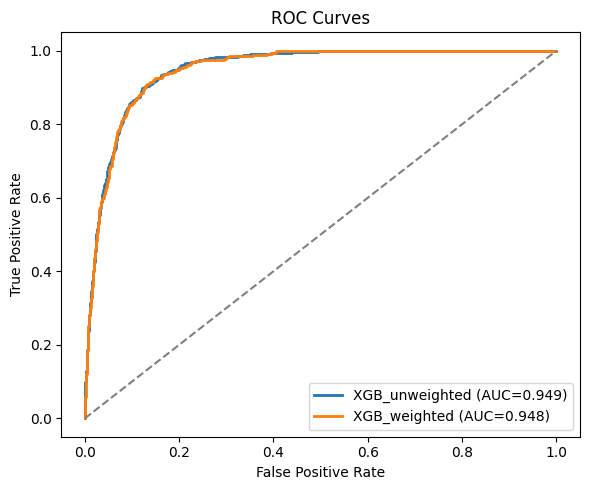

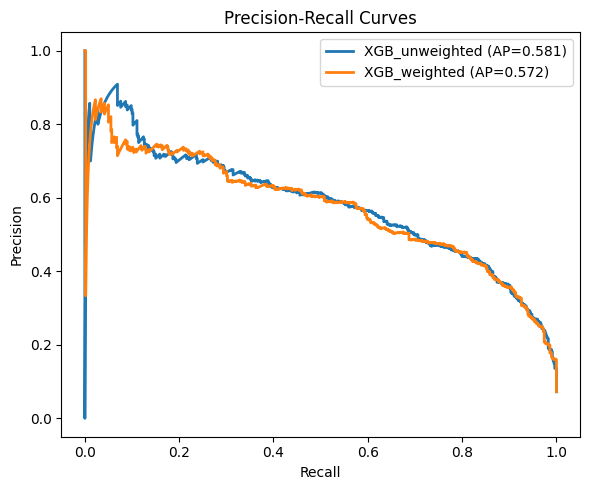

In [11]:
# 1. Compute positive-class weight ratio
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
ratio = neg / pos

# 2. Define two XGBoost variants
models = {
    'XGB_unweighted': XGBClassifier(
        n_estimators=100, max_depth=3,
        use_label_encoder=False, eval_metric='logloss',
        random_state=42
    ),
    'XGB_weighted': XGBClassifier(
        n_estimators=100, max_depth=3,
        scale_pos_weight=ratio,
        use_label_encoder=False, eval_metric='logloss',
        random_state=42
    )
}

# 3. 5-fold CV: accuracy, recall, ROC AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'recall', 'roc_auc']

print("=== 5-FOLD CROSS-VALIDATION ===")
for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    df_cv = pd.DataFrame({
        'accuracy': scores['test_accuracy'],
        'recall':   scores['test_recall'],
        'roc_auc':  scores['test_roc_auc']
    }, index=[f'Fold {i+1}' for i in range(5)])
    
    print(f"\n{name}")
    display(df_cv)
    print("Mean scores:")
    display(df_cv.mean().to_frame(name='mean').T)

# 4. Hold-out evaluation: fit & report
print("\n=== HOLD-OUT EVALUATION ===")
roc_curves = {}
pr_curves = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_hold)
    y_prob = model.predict_proba(X_hold)[:, 1]
    
    print(f"\n{name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_hold, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_hold, y_pred, digits=3))
    print(f"Accuracy: {accuracy_score(y_hold, y_pred):.3f} | ROC AUC: {roc_auc_score(y_hold, y_prob):.3f}")
    
    # store for plotting
    fpr, tpr, _ = roc_curve(y_hold, y_prob)
    roc_curves[name] = (fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_hold, y_prob)
    pr_curves[name] = (precision, recall, average_precision_score(y_hold, y_prob))

# 5. Plot ROC curves
plt.figure(figsize=(6, 5))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc(fpr,tpr):.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 6. Plot Precision-Recall curves
plt.figure(figsize=(6, 5))
for name, (precision, recall, ap) in pr_curves.items():
    plt.plot(recall, precision, lw=2, label=f'{name} (AP={ap:.3f})')
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

      weight  mean_roc_auc  mean_auprc
0   1.000000      0.948046    0.547903
1   5.000000      0.947501    0.546681
2  10.000000      0.946735    0.537789
3  12.810962      0.946459    0.537806


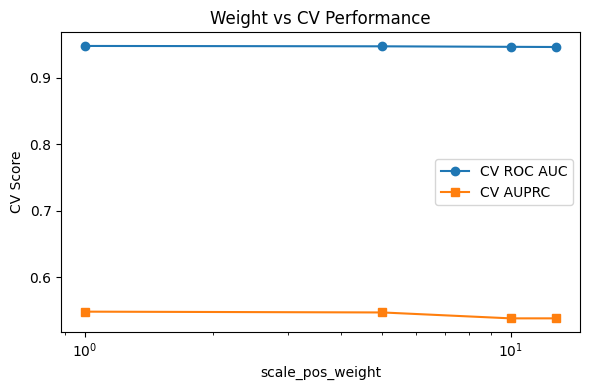

Best scale_pos_weight by CV AUPRC: 1.00


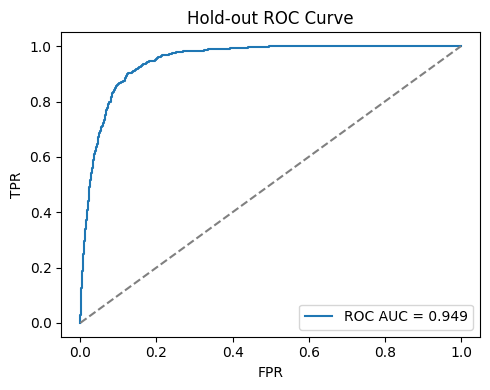

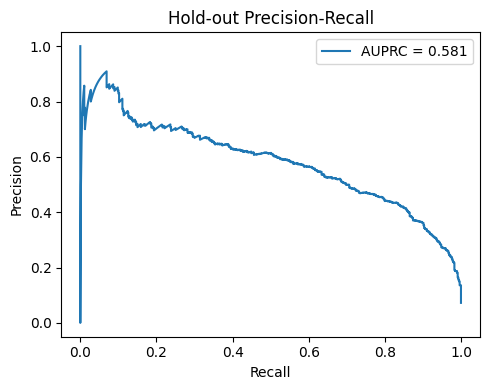

In [12]:
# 1. Recompute positive-class weight ratio
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
ratio = neg / pos

# 2. Define candidate weights to test
weights = [1, 5, 10, ratio]

# 3. Set up CV for AUC and AUPRC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['roc_auc', 'average_precision']
results = []

for w in weights:
    model = XGBClassifier(
        n_estimators=100, max_depth=3,
        scale_pos_weight=w,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    results.append({
        'weight': w,
        'mean_roc_auc': scores['test_roc_auc'].mean(),
        'mean_auprc':   scores['test_average_precision'].mean()
    })

# 4. Summarize and plot CV results
df_res = pd.DataFrame(results)
print(df_res)

plt.figure(figsize=(6, 4))
plt.plot(df_res['weight'], df_res['mean_roc_auc'], marker='o', label='CV ROC AUC')
plt.plot(df_res['weight'], df_res['mean_auprc'], marker='s', label='CV AUPRC')
plt.xscale('log')
plt.xlabel('scale_pos_weight')
plt.ylabel('CV Score')
plt.title('Weight vs CV Performance')
plt.legend()
plt.tight_layout()
plt.show()

# 5. Pick best weight by highest AUPRC
best_w = df_res.loc[df_res['mean_auprc'].idxmax(), 'weight']
print(f"Best scale_pos_weight by CV AUPRC: {best_w:.2f}")

# 6. Refit on full training set with best weight and plot final curves
best_model = XGBClassifier(
    n_estimators=100, max_depth=3,
    scale_pos_weight=best_w,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
best_model.fit(X_train, y_train)
y_prob = best_model.predict_proba(X_hold)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_hold, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Hold-out ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_hold, y_prob)
auprc = average_precision_score(y_hold, y_prob)
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, label=f'AUPRC = {auprc:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Hold-out Precision-Recall')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

CV AUPRC by weight:
      weight  mean_auprc
0   1.000000    0.547903
1   5.000000    0.546681
2  10.000000    0.537789
3  12.810962    0.537806


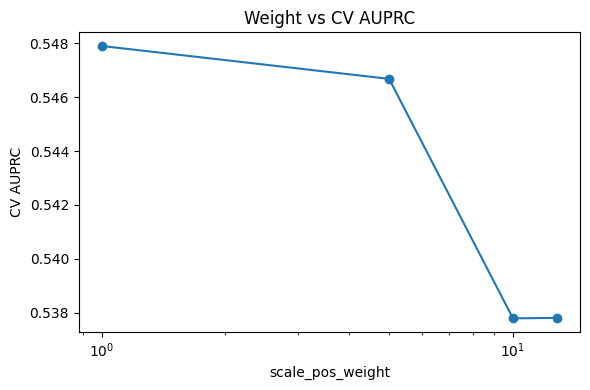

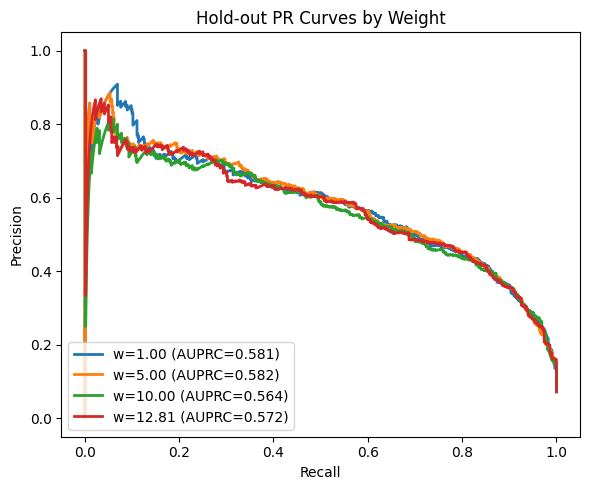

Best scale_pos_weight by CV AUPRC: 1.00


In [17]:
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
ratio = neg / pos
weights = [1, 5, 10, ratio]

# 1a. CV AUPRC for each weight
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for w in weights:
    model = XGBClassifier(
        n_estimators=100, max_depth=3,
        scale_pos_weight=w,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=['average_precision'])
    cv_results.append({'weight': w, 'mean_auprc': scores['test_average_precision'].mean()})
df_weights = pd.DataFrame(cv_results)
print("CV AUPRC by weight:")
print(df_weights)

# 1b. Plot CV AUPRC vs weight
plt.figure(figsize=(6, 4))
plt.plot(df_weights['weight'], df_weights['mean_auprc'], marker='o')
plt.xscale('log')
plt.xlabel('scale_pos_weight')
plt.ylabel('CV AUPRC')
plt.title('Weight vs CV AUPRC')
plt.tight_layout()
plt.show()

# 1c. Hold-out Precision-Recall curves for each weight
plt.figure(figsize=(6, 5))
for w in weights:
    model = XGBClassifier(
        n_estimators=100, max_depth=3,
        scale_pos_weight=w,
        use_label_encoder=False, eval_metric='logloss', random_state=42
    )
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_hold)[:, 1]
    precision, recall, _ = precision_recall_curve(y_hold, y_prob)
    ap = average_precision_score(y_hold, y_prob)
    plt.plot(recall, precision, lw=2, label=f'w={w:.2f} (AUPRC={ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Hold-out PR Curves by Weight')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# 1d. Best weight
best_w = df_weights.loc[df_weights['mean_auprc'].idxmax(), 'weight']
print(f"Best scale_pos_weight by CV AUPRC: {best_w:.2f}")

Best scale_pos_weight by CV AUPRC: 1.00
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best CV AUPRC: 0.551
Hold-out AUPRC: 0.585
